In [1]:
from std_methods import std_methods

tickers = ['AAPL','JPM','F','PG', 'BA']

equal_weights,min_risk,risk_parity = std_methods(tickers,'1992-01-01','2022-18-31','2023-01-01','2023-12-31')

[7.95985831e-12 3.45395956e-11 9.47447097e-01 5.09396416e-02
 1.61326095e-03]
[0.02270654 0.0285299  0.9138212  0.03045487 0.00448748]


In [2]:
import matplotlib.pyplot as plt
import numpy as np

investment_period = 1 # each 1 investment days 
reward_period = 15 # each 15 investment periods

def evaluate_model(model,env):
    done = False
    rewards = []
    portfolio_worths = []
    obs = env.reset()
    portfolio_worths.append(1.0)
    while not done:
        action, _states = model.predict(obs,deterministic=True)
        obs, reward, done,info = env.step(action)
        portfolio_worths.append(info[0]['porfolio_worth'])
        rewards.append(reward)
    return np.array(rewards),np.array(portfolio_worths)

d:\.war\satan\.venv\Lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.15GB > 0.69GB
  warnings.warn(


paper Sharpe Ratio: 0.0660169351874154,  Information Ratio: -0.18598381195932664, Final Portfolio Worth: 1.0977869585348892


d:\.war\satan\.venv\Lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.15GB > 0.64GB
  warnings.warn(


benchmark risk 0 Sharpe Ratio: 0.44783533411870186,  Information Ratio: 0.48618097328359317, Final Portfolio Worth: 1.282492448284652


d:\.war\satan\.venv\Lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.15GB > 0.62GB
  warnings.warn(


benchmark risk 0.25 Sharpe Ratio: 0.4010796207393547,  Information Ratio: 0.36533347304046426, Final Portfolio Worth: 1.2548644694829554


d:\.war\satan\.venv\Lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.15GB > 0.60GB
  warnings.warn(


benchmark risk 0.5 Sharpe Ratio: 0.2897311186156239,  Information Ratio: 0.22780048380571824, Final Portfolio Worth: 1.2344758944505219


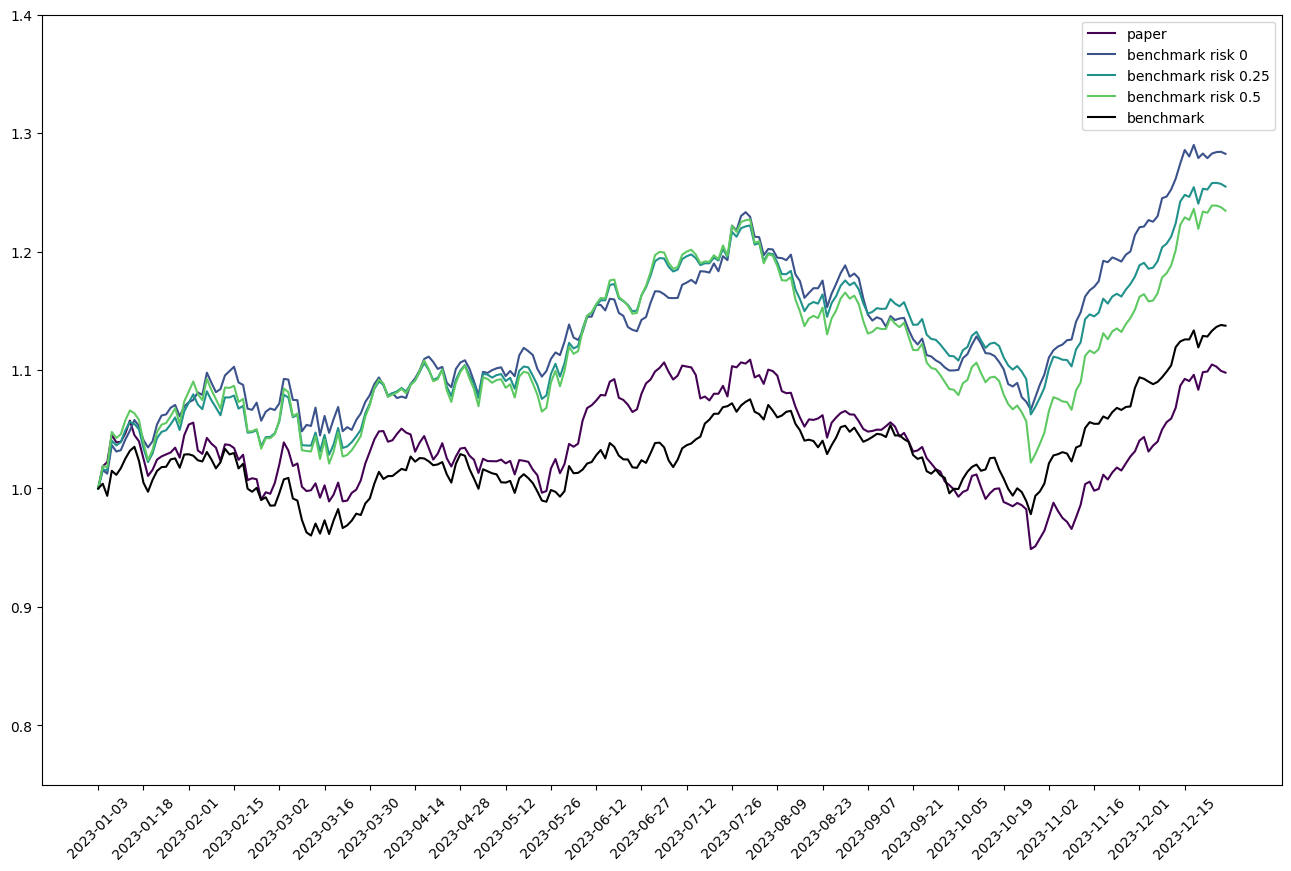

In [3]:
from stable_baselines3 import SAC
from DSAC import DSAC
from enviroments.benchmark import create_env_benchmark

eval_env,eval_dates,eval_benchmark,prices = create_env_benchmark(tickers,'2023-01-01','2023-12-31',investment_period,reward_period)

models = {
    'paper': 'paper',
    'benchmark risk 0': 'SAC_benchmark_risk_0_inv_1_rew_15',
    'benchmark risk 0.25': 'SAC_benchmark_risk_0.25_inv_1_rew_15',
    'benchmark risk 0.5': 'SAC_benchmark_risk_0.5_inv_1_rew_15',
}

plt.figure(figsize=(16,10))
i = 0

def extract_portfolio(eval_env, eval_benchmark, model):
    rewards,portfolio_worths = evaluate_model(model,eval_env)
    monthly_portfolio_worths = portfolio_worths[::25]
    monthly_portfolio_returns = np.diff(monthly_portfolio_worths)/monthly_portfolio_worths[:-1]
    sharpe_ratio = np.mean(monthly_portfolio_returns)/np.std(monthly_portfolio_returns)
    
    monthly_benchmark_worths = eval_benchmark[::25]
    monthly_benchmark_returns = np.diff(monthly_benchmark_worths)/monthly_benchmark_worths[:-1]
    excess_returns = monthly_portfolio_returns - monthly_benchmark_returns
    information_ratio = np.mean(excess_returns)/np.std(excess_returns)
    
    return portfolio_worths,sharpe_ratio,information_ratio

for model_name,model_path in models.items():
    model = SAC.load(f'./models/{model_path}.zip')
        
    portfolio_worths,sharpe_ratio,information_ratio = extract_portfolio(eval_env, eval_benchmark, model)
    print(f'{model_name} Sharpe Ratio: {sharpe_ratio},  Information Ratio: {information_ratio}, Final Portfolio Worth: {portfolio_worths[-1]}')
    
    plt.plot(eval_dates,portfolio_worths, linestyle='-',label=f'{model_name}', color = plt.cm.viridis(i/len(models)))
    i += 1
    
eval_benchmark_relative = eval_benchmark/eval_benchmark[0]

plt.plot(eval_dates,eval_benchmark_relative, linestyle='-',label='benchmark', color = 'black')

plt.xticks(eval_dates[::(len(eval_dates)//25)],rotation=45)
plt.ylim(0.75,1.4)
plt.legend()

Using cpu device


d:\.war\satan\.venv\Lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.15GB > 0.59GB
  warnings.warn(


max gain 0.5 Sharpe Ratio: 0.39101708791922657,  Information Ratio: 0.4066732724648773, Final Portfolio Worth: 1.2401921562282385
Using cpu device


d:\.war\satan\.venv\Lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.15GB > 0.55GB
  warnings.warn(


max gain 0 Sharpe Ratio: 0.0021074979698762005,  Information Ratio: -0.12175744612913587, Final Portfolio Worth: 1.1070227198200946
Using cpu device
max gain 0.25 Sharpe Ratio: 0.1310212640502598,  Information Ratio: 0.06870051759249174, Final Portfolio Worth: 1.2675773636056673


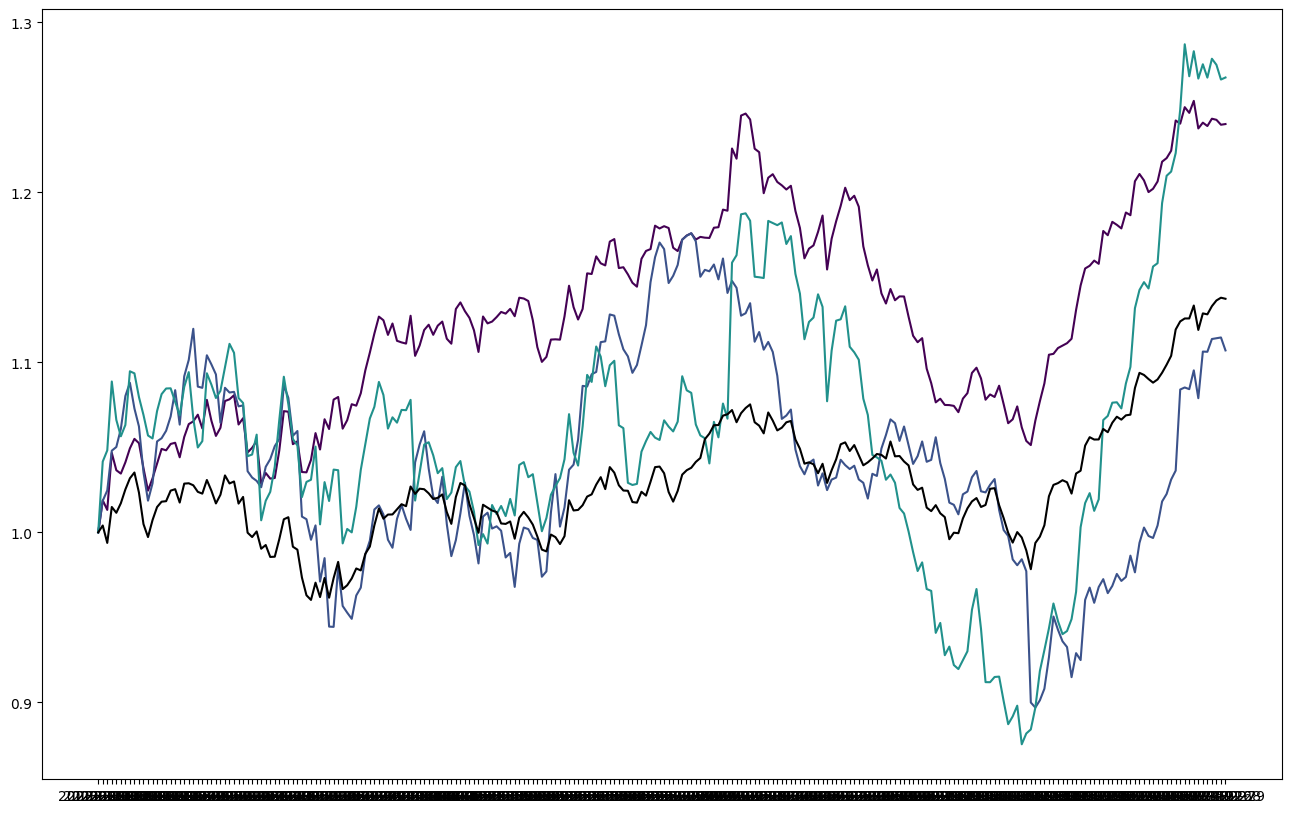

In [4]:
dsac_models = {
    'max gain 0.5': 'DSAC_max_gain_risk_0.5_inv_1_rew_15',
    'max gain 0': 'DSAC_max_gain_risk_0_inv_1_rew_15',
    'max gain 0.25': 'DSAC_max_gain_risk_0.25_inv_1_rew_15',
}

i = 0

plt.figure(figsize=(16,10))

for model_name,model_path in dsac_models.items():
    bare_model = DSAC(policy='MlpPolicy', env=eval_env, verbose=1)
    bare_model.set_parameters(f'./models/{model_path}.zip')
    
    portfolio_worths,sharpe_ratio,information_ratio = extract_portfolio(eval_env, eval_benchmark, bare_model)
    
    print(f'{model_name} Sharpe Ratio: {sharpe_ratio},  Information Ratio: {information_ratio}, Final Portfolio Worth: {portfolio_worths[-1]}')
    
    plt.plot(eval_dates,portfolio_worths, linestyle='-',label=f'{model_name}', color = plt.cm.viridis(i/len(models)))
    
    i += 1
    
plt.plot(eval_dates,eval_benchmark_relative, linestyle='-',label='benchmark', color = 'black')